In [1]:
import torch
from torch_geometric.data import Data

# Social Network Graph Dataset: Classifying by DeepWalk and Node2Vec

When we want to do node classifications, we need to specify how we want to select or represent our x_features. There are several way to do it:

    - simplest way => x_features = Node degree. I nother words, each node is connected to how many other nodes. ==> G.degree().
        - In other words: x_feature = node_degrees ==> x_feature = [XX]. Here the size of x_feature will be 34 X 1, since we have 34 nodes.
    - A little more elaborated => use learning-based methods like node embeddings. Embedding acts similar to Word2Vec in NLP and provides us a vector for each node. x_feature = [XX, XX, ...]. Later here, since we select our embedding size as 124, and since we have 34 nodes in this dataset, the x_feature size will be 34 X 124.
    
    

What is our dataset?

    - It is a social network example, in which Karate club members represented in a Graph
    - A social network of a karate club in which Karate club members represented in a Graph
    - The network captures 34 members/students of a karate club, documenting 78 links between pairs of members who interacted outside the club. 
    - Two classes: In the A conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two.
    
As seen in the graph below, it seems member34 contacted many people. As example, contact for member2 to member8 is shown below:

    [2 1]
    [3 1] [3 2]
    [4 1] [4 2] [4 3]
    [5 1]
    [6 1]
    [7 1] [7 5] [7 6]
    [8 1] [8 2] [8 3] [8 4]

<img src="img\zachary_karate_graph.png" width="750" height="750"/>


# Drawing the graph: why embedding might be helpful as x_feature

- Below, as we see, members of the karate clubs talk mainly to their club members. Only a few members (nodes) are connected to the opposite coloured nodes. This information could be very valuable for e.g. classification or community detection tasks and we can represent it using the node embeddings.
- DeepWalk (and any other neighbourhood based node embedding algorithm) represents the nodes as vectors which capture some neighbourhood information from the graph.
- Using DeepWalk each karate club member (node) is now represented by a vector of size 124. These vectors should reflect the graph neighbourhoods, i.e. the different clubs should be far away from each other.


Reference:
https://antonsruberts.github.io/graph/deepwalk/

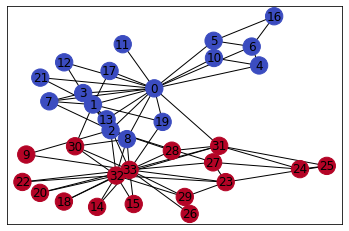

In [18]:
G = nx.karate_club_graph()

clubs = []  # list to populate with labels
for n in G.nodes:
    c = G.nodes[n]['club']  # karate club name, can be either 'Officer' or 'Mr. Hi'
    clubs.append(1 if c == 'Officer' else 0)

pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm') # Plot the graph

# Embedding

In [19]:
import karateclub
# each node is represented by a vetor of size 124
model = karateclub.DeepWalk(dimensions=124)  # node embedding algorithm
model.fit(G)  # fit it on the graph
embedding = model.get_embedding()  # extract embeddings

print('Number of karate club members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number of karate club members: 34
Embedding array shape: (34, 124)


# How good the generated embedding for the nodes

- Below here, the size of the embeddings is 124, so we need to employ t-SNE which is a dimensionality reduction technique. Basically, t-SNE transforms the 124 dimension array into a 2-dimensional array so that we can visualize it in a 2D space.

- We can see that the embeddings generated for this graph are of good quality as there is a clear separation between the red and blue points. Now we can build a graph neural network model which trains on these embeddings and finally, we will have a good prediction model.

C:\Users\Hafez\Desktop\test\venv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


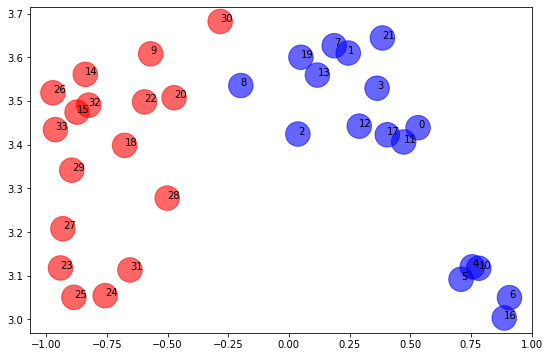

In [21]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# retrieve the labels for each node
labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# assigning colours to node labels
color_map = []
for i in labels:
    if i == 0:
        color_map.append('blue')
    else: 
        color_map.append('red')  

# transform the embeddings from 128 dimensions to 2D space
m = TSNE(learning_rate=20, random_state=42)
tsne_features = m.fit_transform(embedding)

# plot the transformed embeddings
plt.figure(figsize=(9,6)) 
plt.scatter(x = tsne_features[:,0], 
            y = tsne_features[:,1],
            c = color_map,
            s =600,
            alpha=0.6)

# adds annotations
for i, label in enumerate(np.arange(0,34)):
    plt.annotate(label, (tsne_features[:,0][i], tsne_features[:,1][i]))

# save the visualization
plt.savefig('tsne.png', bbox_inches='tight',dpi = 1000)

# Preprocessing:  
Generate numerical representations for each node in the graph (node degree in this case).

    - Reading the Karate_club graph data from networkx
    - Defining the labels (for each 34 nodes)
    - adjacent matrix [in COO sprse format]
    - Edge data in COO coordinate (the edge_index)
    - x_feature = Embedding ==> here we use DeepWalk to have a representation of each node
    - y_label = Two classes:
        G.nodes[1] ==> {'club': 'Mr. Hi'}
        G.nodes[9] ==> {'club': 'Officer'}
    - x_feature [=embedding] and edge_index are useful as input to PyG convloutional layer [this is how the library written]:
        self.conv1(x_feature, edge_index)

Using COO to save sparse matrix in memory ==> https://matteding.github.io/2019/04/25/sparse-matrices/


In [22]:
import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# load graph from networkx library
G = nx.karate_club_graph()

# retrieve the labels for each node ==> convert True/False to 0/1 for a binary classifications
labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# print("# of nodes: ", G.number_of_nodes())
# print("nodes in G: ", G.nodes())

In [23]:
# create edge index from
# good source on how to store a sparse matrix in COO format: ==> https://matteding.github.io/2019/04/25/sparse-matrices/
adj = nx.to_scipy_sparse_matrix(G).tocoo() # sparsematrix object in COO coordinate and format

rows_idx = adj.row.astype(np.int64) # getting row idx in COO format
col_idx = adj.col.astype(np.int64) # getting col idx in COO format

rows_idx_torch = torch.from_numpy(rows_idx).to(torch.long)
col_idx_torch = torch.from_numpy(col_idx).to(torch.long)

edge_index = torch.stack([rows_idx_torch, col_idx_torch], dim=0) # edge idx is simply what node is connected to what node

# using degree as embedding ==> basically each node is connected to how many other nodes
# print("Grapgh degree: ",  dict(G.degree())   )
# embeddings = np.array(list( dict(G.degree()).values() ))

# normalizing degree values
scale = StandardScaler()
# embeddings = scale.fit_transform(embeddings.reshape(-1,1))  # make it N-rows and 1 column. x_feature:size: 34 X 1
embeddings = torch.from_numpy(embedding)

# The PyG Custom Dataset

The KarateDataset class inherits from the InMemoryDataset class and use a Data object to collate all information relating to the karate club dataset. The graph data is then split into train and test sets, thereby creating the train and test masks using the splits.

The data object contains the following variables:

    - "Data(edge_index=[2, 156], num_nodes=34, x=[34, 1], y=[34], num_classes=2, train_mask=[34], test_mask=[34])"
    - As seen above, the feature vector, x, for each of 34 node is a vector of size 1. It can be a size of m in more complex problems



This custom dataset can now be used with **several graph neural network models** from the Pytorch Geometric library. Let’s pick a **Graph Convolutional Network model** and use it to predict the missing labels on the test set.

$Note$: PyG library focuses more on _node classification task_ but it can also be used for _link prediction_.

Reference:
https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#exercises

In [27]:
import torch
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T


# PyG custom dataset
class KarateDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(KarateDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = G.number_of_nodes()
        
        # embedding = x_feature ==> here for simplicity x_feature for each node = here embedding vector
        data.x = embeddings.type(torch.float32)
        
        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2

        # splitting the data into train, validation and test
        X_feature_only_for_indexing = pd.Series(list(G.nodes())) 
        y_label = pd.Series(labels)
        X_train, X_test, y_train, y_test = train_test_split(X_feature_only_for_indexing, 
                                                            y_label,
                                                            test_size=0.30, 
                                                            random_state=42)
#         print(X_train)
#         print(X_train.index)

        
        n_nodes = G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask
#         print(train_mask)
#         print(data['train_mask'])

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = KarateDataset()
data = dataset[0]

In [28]:
data

Data(edge_index=[2, 156], num_nodes=34, x=[34, 124], y=[34], num_classes=2, train_mask=[34], test_mask=[34])

In [29]:
# print(data.train_mask)
# print(data.x) # will print the scaled embedding of size = 34X1
# print(data.y) # print labels

# Graph Convolutional Network.

In [30]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN with 2 layers
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, int(data.num_classes))

    def forward(self):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data =  data.to(device)

model = Net().to(device)

# Train the GCN model

In [31]:

torch.manual_seed(42)

optimizer_name = "Adam"
lr = 1e-1
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
epochs = 200

def train():
    model.train()
    optimizer.zero_grad()
    y_pred = model()[data.train_mask]
    y_lable = data.y[data.train_mask] 
    F.nll_loss(y_pred, y_lable).backward()
    optimizer.step()

@torch.no_grad()
def test():
    model.eval()
    logits = model()
    # for traning set
    mask1 = data['train_mask']
    pred1 = logits[mask1].max(1)[1]
    label1 = data.y[mask1]
    acc_train = pred1.eq(label1).sum().item() / mask1.sum().item()
    # for test set
    mask = data['test_mask']
    pred = logits[mask].max(1)[1]
    acc_test = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc_train,acc_test

for epoch in range(1, epochs):
    train()

train_acc,test_acc = test()

print('#' * 70)
print('Train Accuracy: %s' %train_acc )
print('Test Accuracy: %s' % test_acc)
print('#' * 70)

######################################################################
Train Accuracy: 1.0
Test Accuracy: 1.0
######################################################################


# Reference:
https://towardsdatascience.com/a-beginners-guide-to-graph-neural-networks-using-pytorch-geometric-part-1-d98dc93e7742